In [29]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import random
import gc as gc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

from sklearn.preprocessing import MinMaxScaler
import datetime
import numpy as np
import matplotlib.pyplot as plt

from models.aae_pyramid import Encoder, Decoder, Discriminator, gaussian_sample
from tools.viz import plot_anomaly_scores, plot_train_hist, plot_data_values
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.method = "single_mag"
        self.scaler = MinMaxScaler((0,1))
        self.l_dim = 2
        self.remove_extreme = True
        # self.wsize = 5
        
        # Train params
        self.G_lr = 0.0001
        self.D_lr = 0.0002
        self.epochs = 400
        self.sample_interval = 100
        self.train_plots = True
        self.nclusters = 2
        
        # create ouput dirs
        self.model_out = Path('./runs/aae_pyr/' + time_id)
        
        # logging
        self.tags = ["aae_pyr", "joint", "minmax", "test"]
        self.desc = "Magnetic Field"
        self.type = "PYR AAE"
        
opts = Options()


# Setup Training Dataset

In [30]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=opts.remove_extreme,
    is_train=True,
    scaler=opts.scaler,
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Inputs shape: (11066, 640)
Inputs head:
 [[0.25825445 0.25848101 0.25870853 ... 0.99991577 0.99992418 0.99993177]
 [0.26357888 0.2638036  0.26402926 ... 0.99993266 0.99993938 0.99994545]
 [0.27695434 0.27718189 0.27741038 ... 0.99993529 0.99994174 0.99994757]
 [0.25461553 0.25483148 0.25504835 ... 0.99994008 0.99994606 0.99995146]
 [0.27191478 0.27212993 0.27234597 ... 0.99993302 0.99993971 0.99994574]]


In [31]:
# dataset.plot(title="Joint Vars")

In [32]:
len(dataloader.dataset)

11066

In [34]:
def epoch_eval(gopts, points, filenames, epoch):
    _, centroids = gaussian_sample(0, gopts)

    distances = []
    for point in points:
        dup_array = np.repeat([point], len(centroids), axis=0)
        distances.append(np.linalg.norm(dup_array-centroids, axis=1))
        

    file_dists = list()
    for filename, dists in zip(filenames, distances):
        file_dists.append((filename, min(dists)))
        

    thresh, _ =\
        plot_anomaly_scores(file_dists, 0.03, opts.data_path, opts.model_out /  f"img/euclidean_dist{epoch}",
                            scale="log", method="Euclidean Distance", normal_plot=True)
    categories = list()
    for _filename, dist in file_dists:
        categories.append("r" if dist > thresh else "b")
        
    fig, ax = plt.subplots(figsize=(10,10), dpi=200)
    plt.scatter(points[:, 0], points[:, 1], s=1, c=categories)
    plt.savefig(opts.model_out / f"img/scatter_dist{epoch}", dpi=200)
    plt.close(fig)
    
    plt.close("all")
    
        

# Models

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
netEnc = Encoder(
    input_size=dataset.shape[1],
    hidden_size=512,
    l_dim=opts.l_dim,  
    device=device,
    slope=0.2
).to(device)

netDec = Decoder(
    output_size=dataset.shape[1],
    l_dim=opts.l_dim,
    hidden_size=32,
    slope=0.2
).to(device)

netD = Discriminator(
    l_dim=opts.l_dim,
    hidden_size=256,
    slope=0.2
).to(device)

Using device:  cuda:0


In [36]:
netEnc.train()

Encoder(
  (model): Sequential(
    (0): Linear(in_features=640, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [37]:
netDec.train()

Decoder(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Linear(in_features=512, out_features=640, bias=True)
    (11): Sigmoid()
  )
)

In [38]:
netD.train()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [39]:
if not opts.model_out.exists(): opts.model_out.mkdir(parents=True), (opts.model_out / "img").mkdir(exist_ok=True)

logger = Logger([netEnc, netDec, netD], opts.model_out / f"{time_id}.md", vars(opts))

# Training

In [40]:
# Initialize BCELoss function
criterion = nn.BCELoss()
reconstr_loss = nn.MSELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

optmEnc = optim.Adam(netEnc.parameters(), lr=opts.G_lr)
optmDec = optim.Adam(netDec.parameters(), lr=opts.G_lr)
optmD = optim.Adam(netD.parameters(), lr=opts.D_lr)

# Training Loop
# Lists to keep track of progress
G_losses = []
D_losses = []
best_loss = np.inf

class GaussianOpts:
    def __init__(self) -> None:
        self.nclusters = opts.nclusters
        self.radius = 1
        self.sigma = 0.02 # dispersion of the cluster
        self.dim = 2      # dimentionality of each guassian distribution
        
gopts = GaussianOpts()
        

In [41]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    epoch_reconstr_loss = 0
    D_class = 0
    epoch_enc_x = np.empty((0, opts.l_dim))
    epoch_filenames = []
    
    # For each batch in the dataloader
    for i, (x, filenames) in enumerate(dataloader):
        bsize = x.shape[0]
        real_labels = torch.full((bsize, 1), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((bsize, 1), fake_label, dtype=torch.float, device=device)
        
        real = x.to(device)
        # ===== Train Generator =====
        optmEnc.zero_grad(), optmDec.zero_grad()
        enc_x = netEnc(real)
        dec_x = netDec(enc_x)
        
        errG = (reconstr_loss(dec_x, real) + criterion(netD(enc_x), real_labels)) * 0.5
        errG.backward()
        optmEnc.step(), optmDec.step()
        epoch_reconstr_loss += errG.item()
        
        
        # ===== Train Discriminator =====
        optmD.zero_grad()
        # noise as discriminator ground truth
        z_sample, _ = gaussian_sample(bsize, gopts)
        z = torch.from_numpy(z_sample).float().to(device)
        
        # z = torch.randn(bsize, opts.l_dim, device=device)
        
        # discriminator ability to classify real from generated samples
        outputs = netD(z)
        errD_real = criterion(outputs, real_labels)
        errD_fake = criterion(netD(enc_x.detach()), fake_labels)    
        errD = (errD_real  + errD_fake) * 0.5
        D_class += outputs.mean().item()
        epoch_enc_x = np.vstack((epoch_enc_x, enc_x.detach().cpu().numpy()))
        epoch_filenames.extend(filenames)
        
        errD.backward()
        optmD.step()
        D_epoch_loss += errD.item()
        G_epoch_loss += errG.item()
    
    D_epoch_loss /= i
    G_epoch_loss /= i
    epoch_reconstr_loss /= i
    D_class /= i
        
    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(z): %.4f\tDec_Err: %.4f'
            % (epoch, opts.epochs, D_epoch_loss, G_epoch_loss, D_class, epoch_reconstr_loss),
            end='\r', flush=True)
    D_losses.append(errD.item())
    G_losses.append(errG.item())
    
    if epoch % opts.sample_interval == 0 or epoch == opts.epochs-1:
        dec_x = dataloader.dataset.unscale(dec_x.detach().cpu().numpy())
        # fake = dataset.flatten(fake.detach().cpu().numpy())
        fig = plot_data_values(dec_x, 
                        title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f}", 
                        labels=["B [G]", "alpha [deg]"],
                        scales={"alpha [deg]" : "symlog"})
        plt.savefig(opts.model_out / "img" / f"e{epoch}.png")
        plt.close(fig)
        
        # save scatter of latent representation by the encoder
        fig, ax = plt.subplots(figsize=(10,10))
        plt.scatter(epoch_enc_x[:, 0], epoch_enc_x[:, 1], s=1)
        plt.savefig(opts.model_out / "img" / f"scatter{epoch}.png")
        plt.close(fig)
        
        # if epoch != 0:
        #     epoch_eval(gopts, epoch_enc_x, epoch_filenames, epoch)
        #     del epoch_enc_x, epoch_filenames
        gc.collect()
        
    if G_epoch_loss < best_loss and epoch > 0:
        best_loss = G_epoch_loss
        torch.save(netEnc.state_dict(), opts.model_out / 'Enc.pth')
        torch.save(netDec.state_dict(), opts.model_out / 'Dec.pth')
        torch.save(netD.state_dict(), opts.model_out / 'D.pth')

Starting Training Loop...


In [42]:
# G_losses, D_losses = train(netEnc, netDec, netD, dataloader, opts, device)

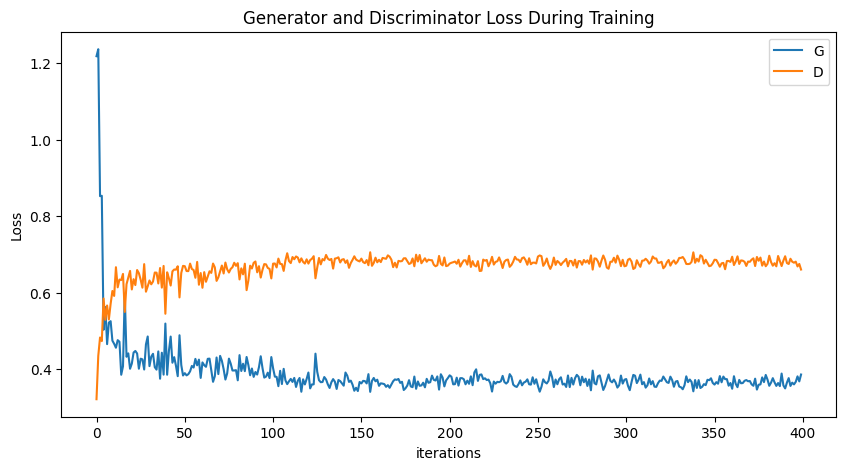

In [43]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [57]:
# netEnc.eval()
# netDec.eval()
# netD.eval()

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    models_dir = Path("./runs/aae_pyr/0404-1707")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netEnc.load_state_dict(torch.load(opts_eval.models_dir / 'Enc.pth'))
netDec.load_state_dict(torch.load(opts_eval.models_dir / 'Dec.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'D.pth'))

netEnc.eval()

Encoder(
  (model): Sequential(
    (0): Linear(in_features=640, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [58]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 640)
Inputs head:
 [[0.25825445 0.25848101 0.25870853 ... 0.99991577 0.99992418 0.99993177]
 [0.26357888 0.2638036  0.26402926 ... 0.99993266 0.99993938 0.99994545]
 [0.27695434 0.27718189 0.27741038 ... 0.99993529 0.99994174 0.99994757]
 [0.25461553 0.25483148 0.25504835 ... 0.99994008 0.99994606 0.99995146]
 [0.27191478 0.27212993 0.27234597 ... 0.99993302 0.99993971 0.99994574]]


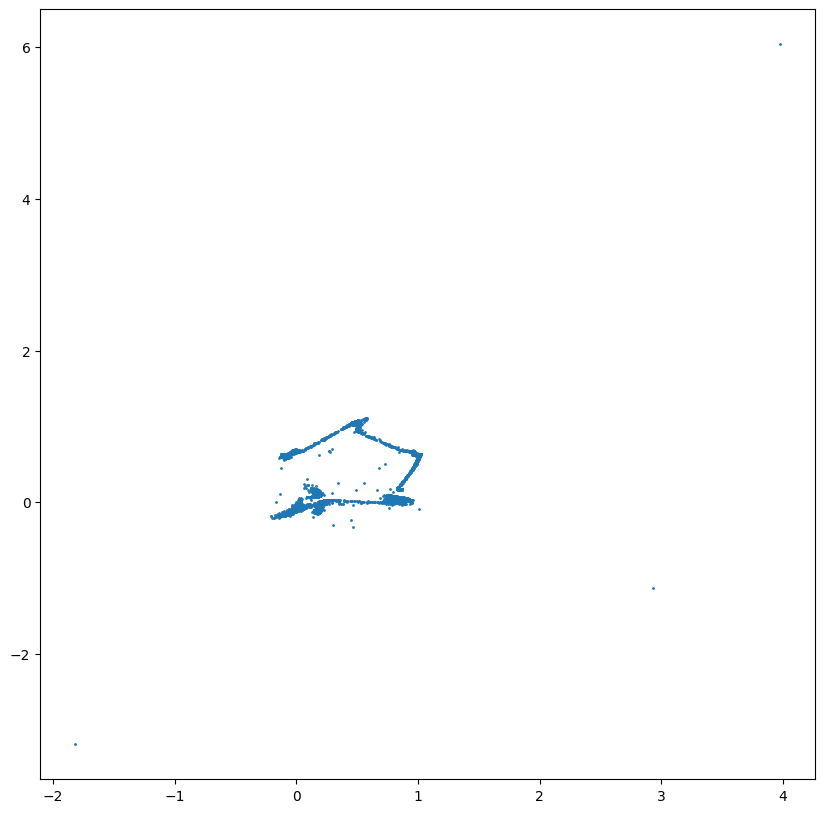

In [59]:

points = np.empty((0, opts.l_dim))
for _i, (x, _filename) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    enc_x = enc_x.detach().cpu().numpy()
    points = np.vstack([points, enc_x])
    # points.extend(list(enc_x))
    
points = np.array(points)

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(points[:, 0], points[:, 1], s=1)
# plt.savefig(opts.model_out / "img" / "test_scatter.png")



In [60]:
print(points.shape)

(11771, 2)


In [61]:
_, centroids = gaussian_sample(0, gopts)

distances = []
for point in points:
    dup_array = np.repeat([point], len(centroids), axis=0)
    distances.append(np.linalg.norm(dup_array-centroids, axis=1))
    

file_dists = list()
for filename, dists in zip(eval_dataset.filenames, distances):
    file_dists.append((filename, min(dists)))
    
    
        

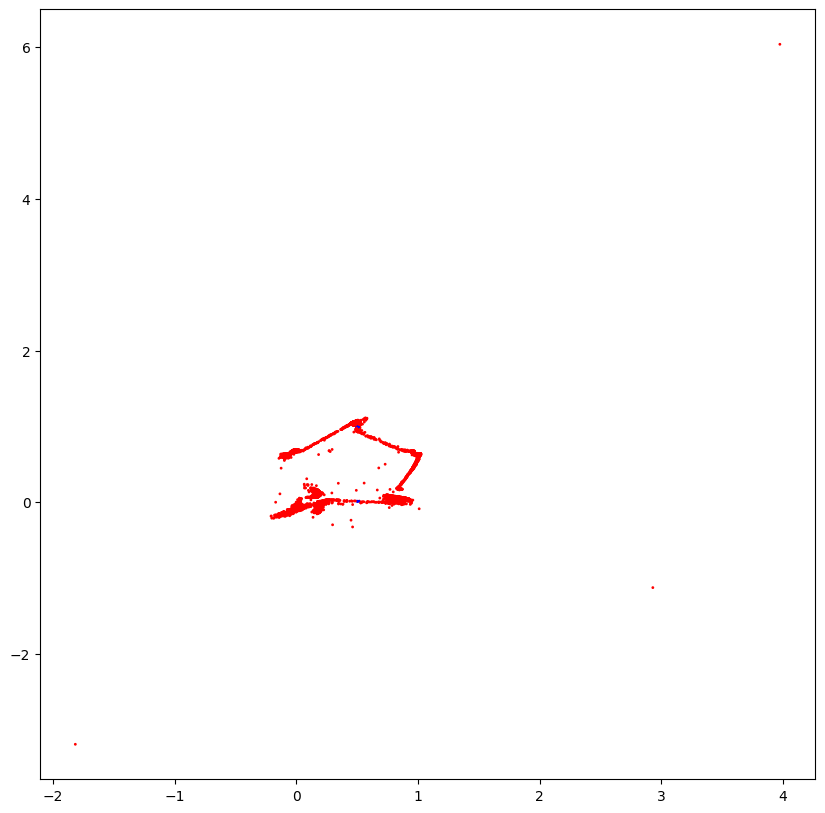

In [62]:
categories = list()
for _filename, dist in file_dists:
    categories.append("r" if dist > 0.02 else "b")
    
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(points[:, 0], points[:, 1], s=1, c=categories)

Anomaly Threshold:  0.6436185720984928
Found 1177 anomalies


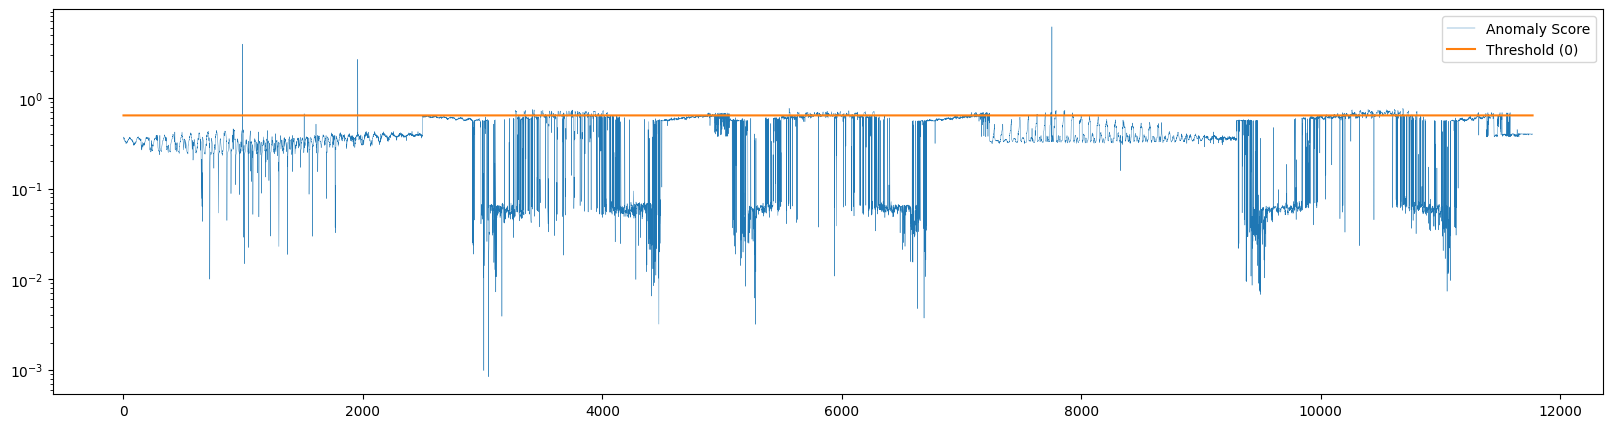

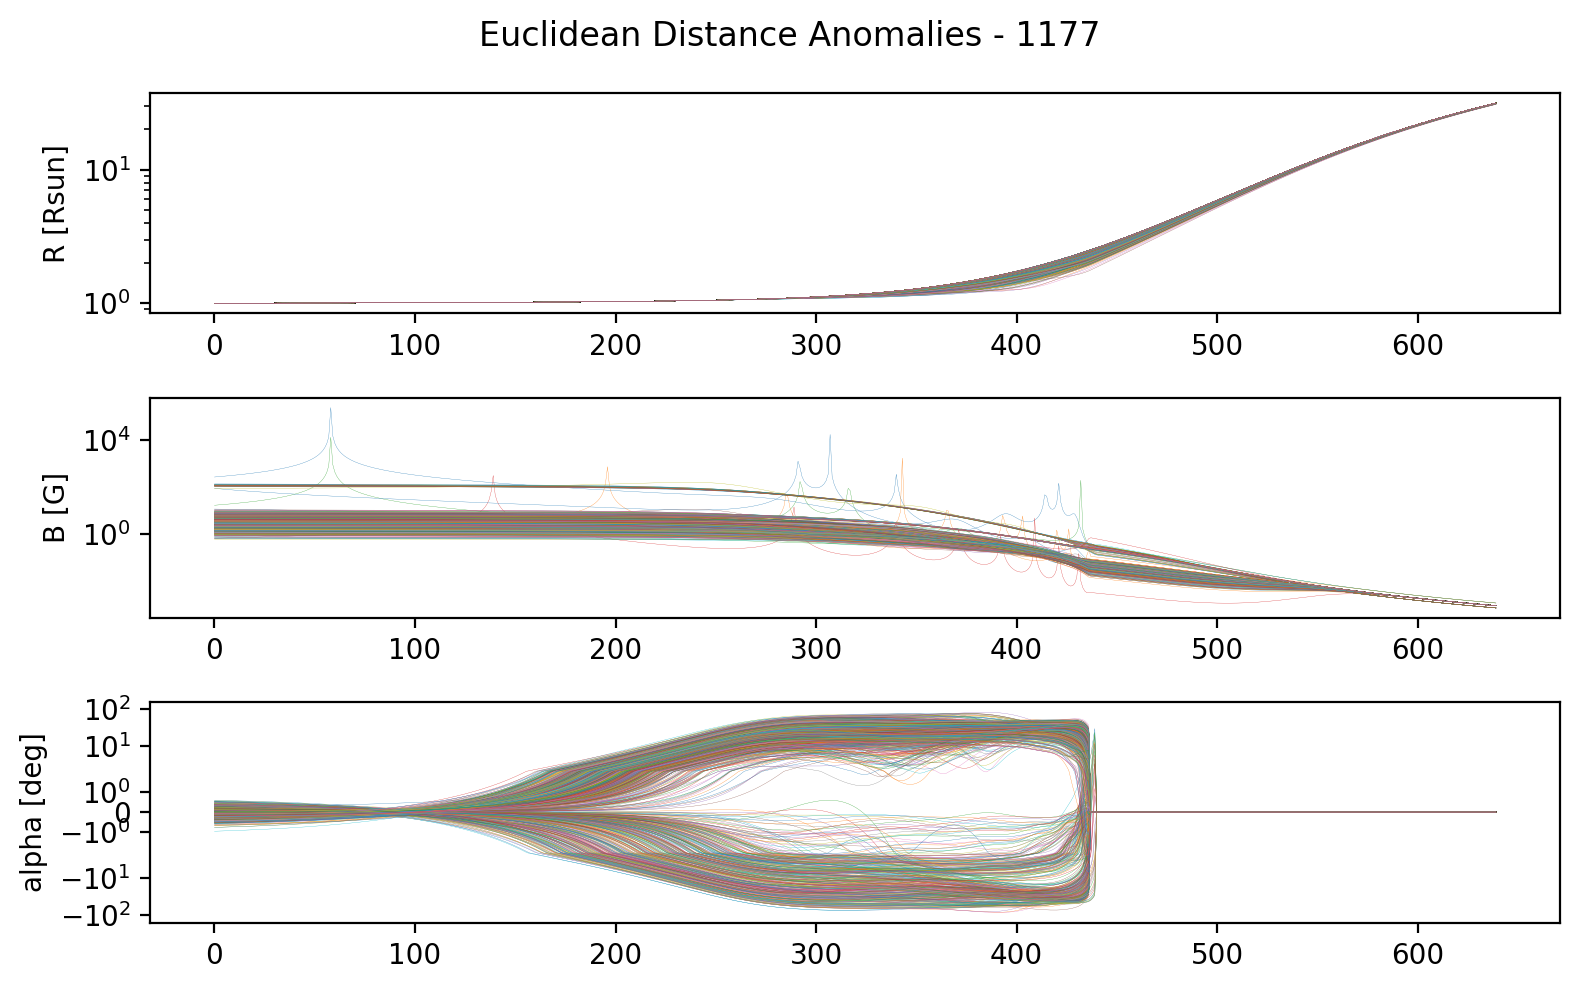

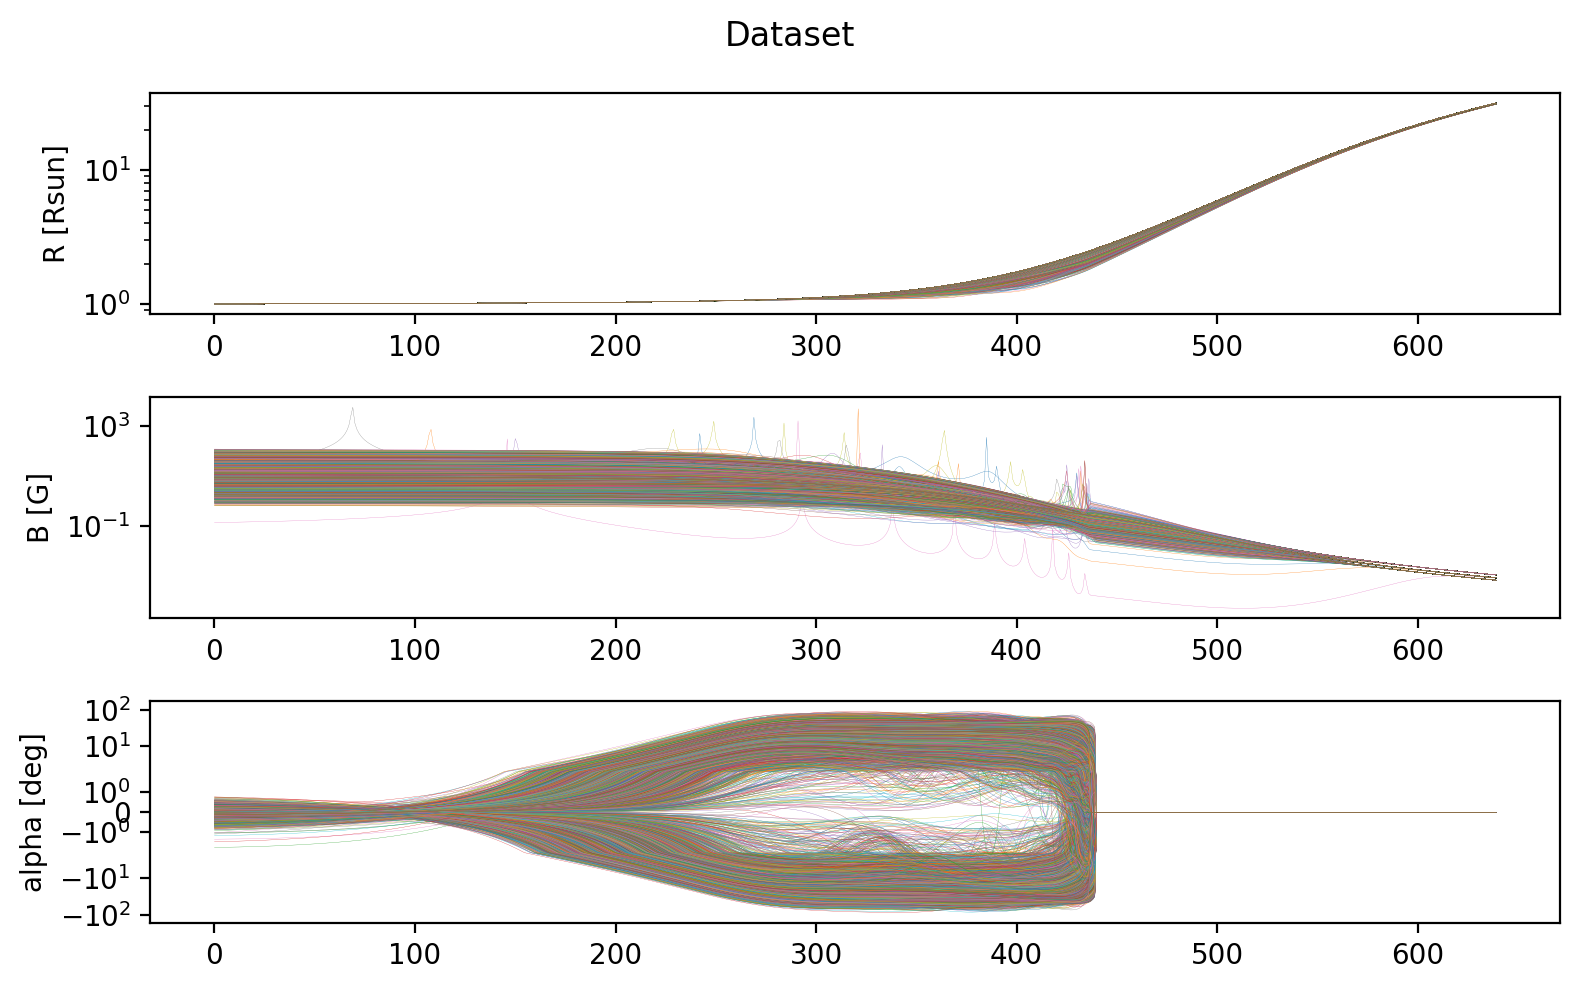

In [63]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(file_dists, 0.1, opts.data_path, opts_eval.models_dir /  f"img/euclidean_dist",
                        scale="log", method="Euclidean Distance", normal_plot=True)

## Discriminator Classification

In [64]:
scores_discr = []
loss_fn = nn.MSELoss(reduction="none")
criterion = nn.BCELoss(reduction="none")

# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    bsize = x.shape[0]
    real_labels = torch.full((bsize, 1), 1, dtype=torch.float, device=device)
    
    errG = criterion(netD(enc_x), real_labels)
    errG = errG.detach().cpu().numpy()
    # errG = loss_fn(dec_x, x).mean(-1)
    # errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        scores_discr.append((filename, error[0]))

# TODO: Rever isto

Anomaly Threshold:  0.71351177
Found 1177 anomalies


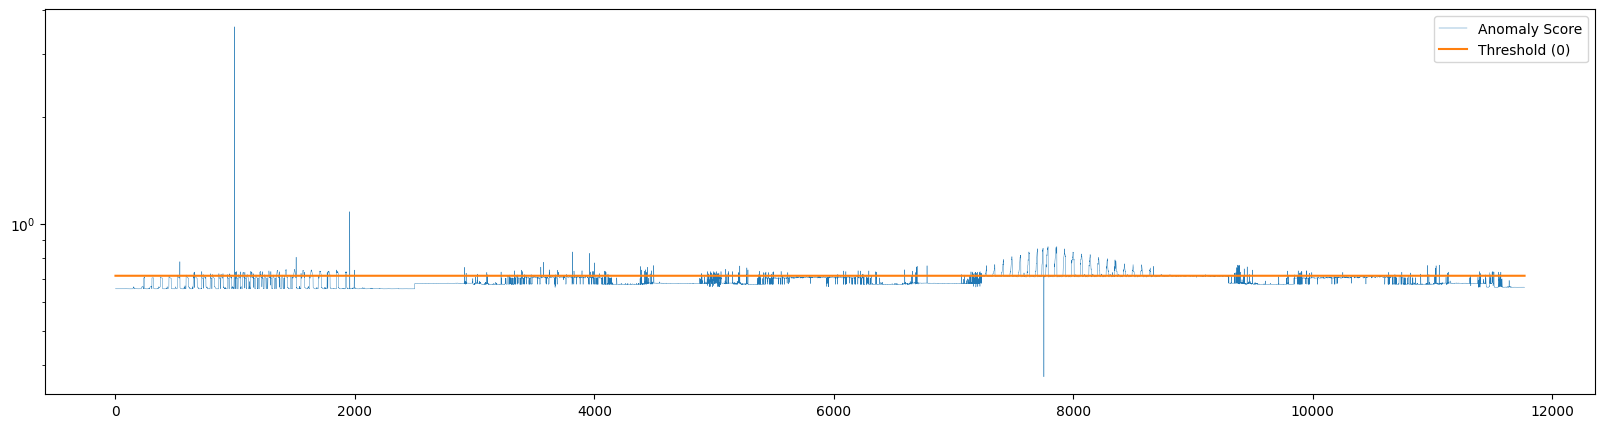

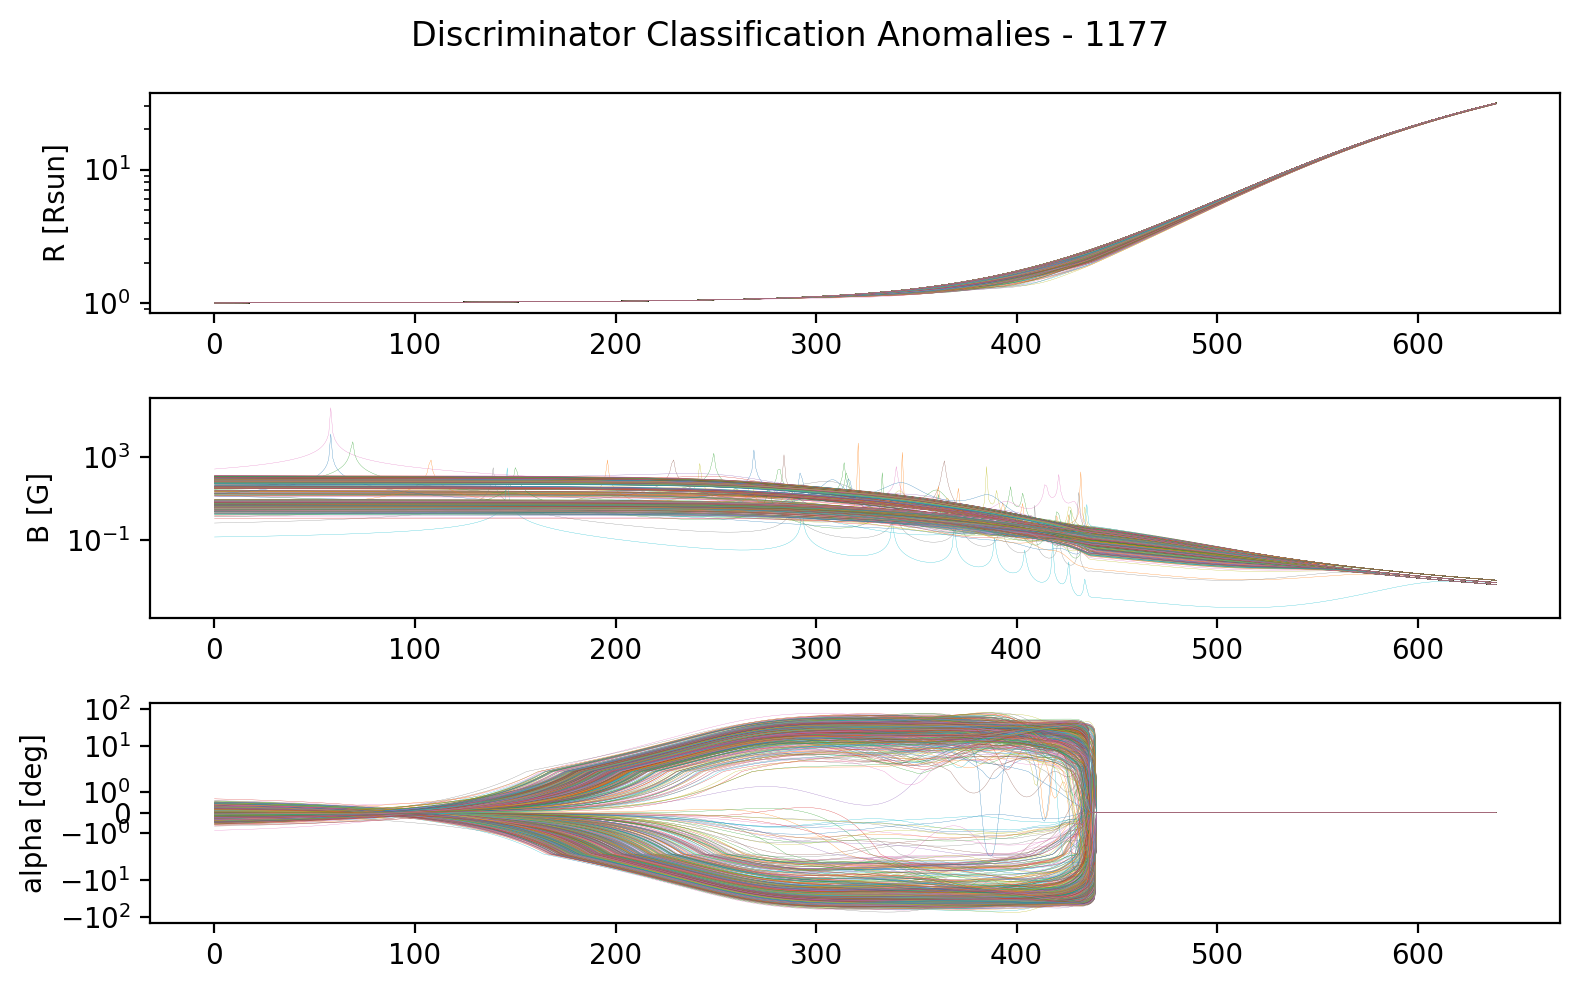

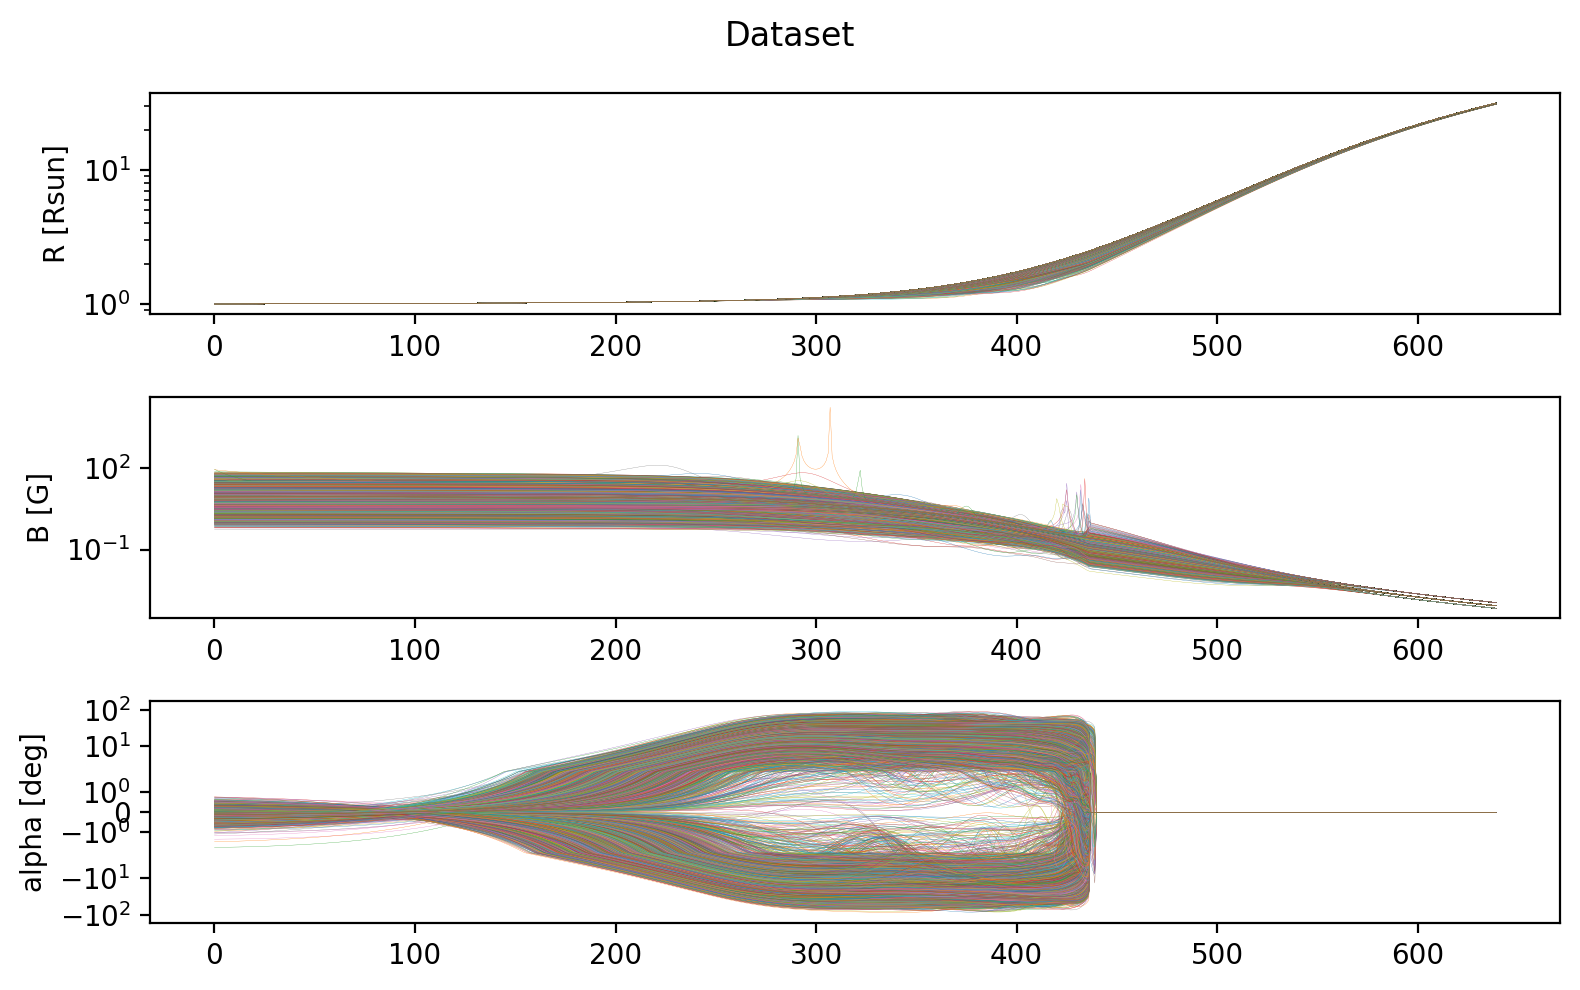

In [65]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/reconstr_scores",
                        scale="log", method="Discriminator Classification", normal_plot=True)

## Reconstruction Error

In [66]:
scores = []
loss_fn = nn.MSELoss(reduction="none")
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    errG = loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        scores.append((filename, error))

Anomaly Threshold:  0.004590144846588373
Found 1177 anomalies


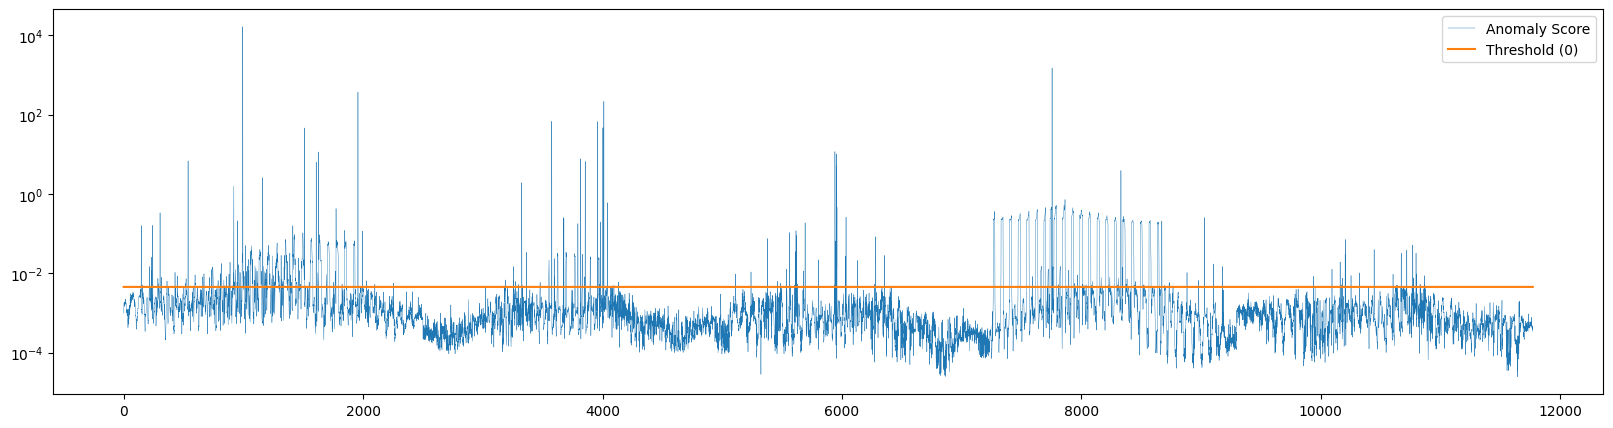

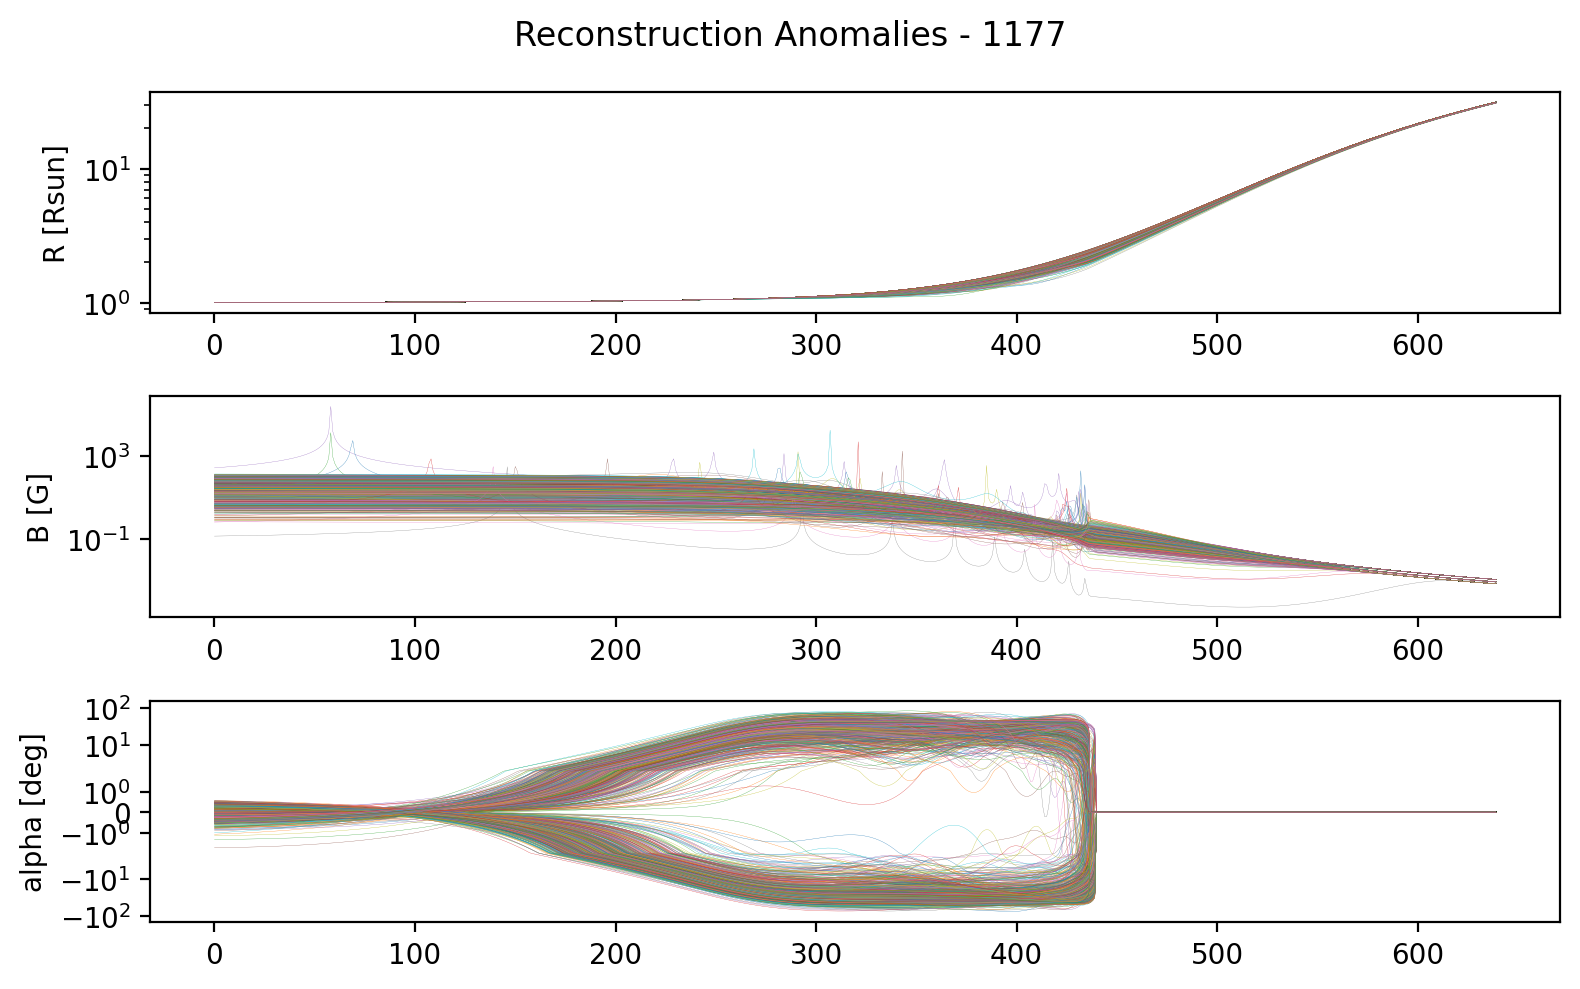

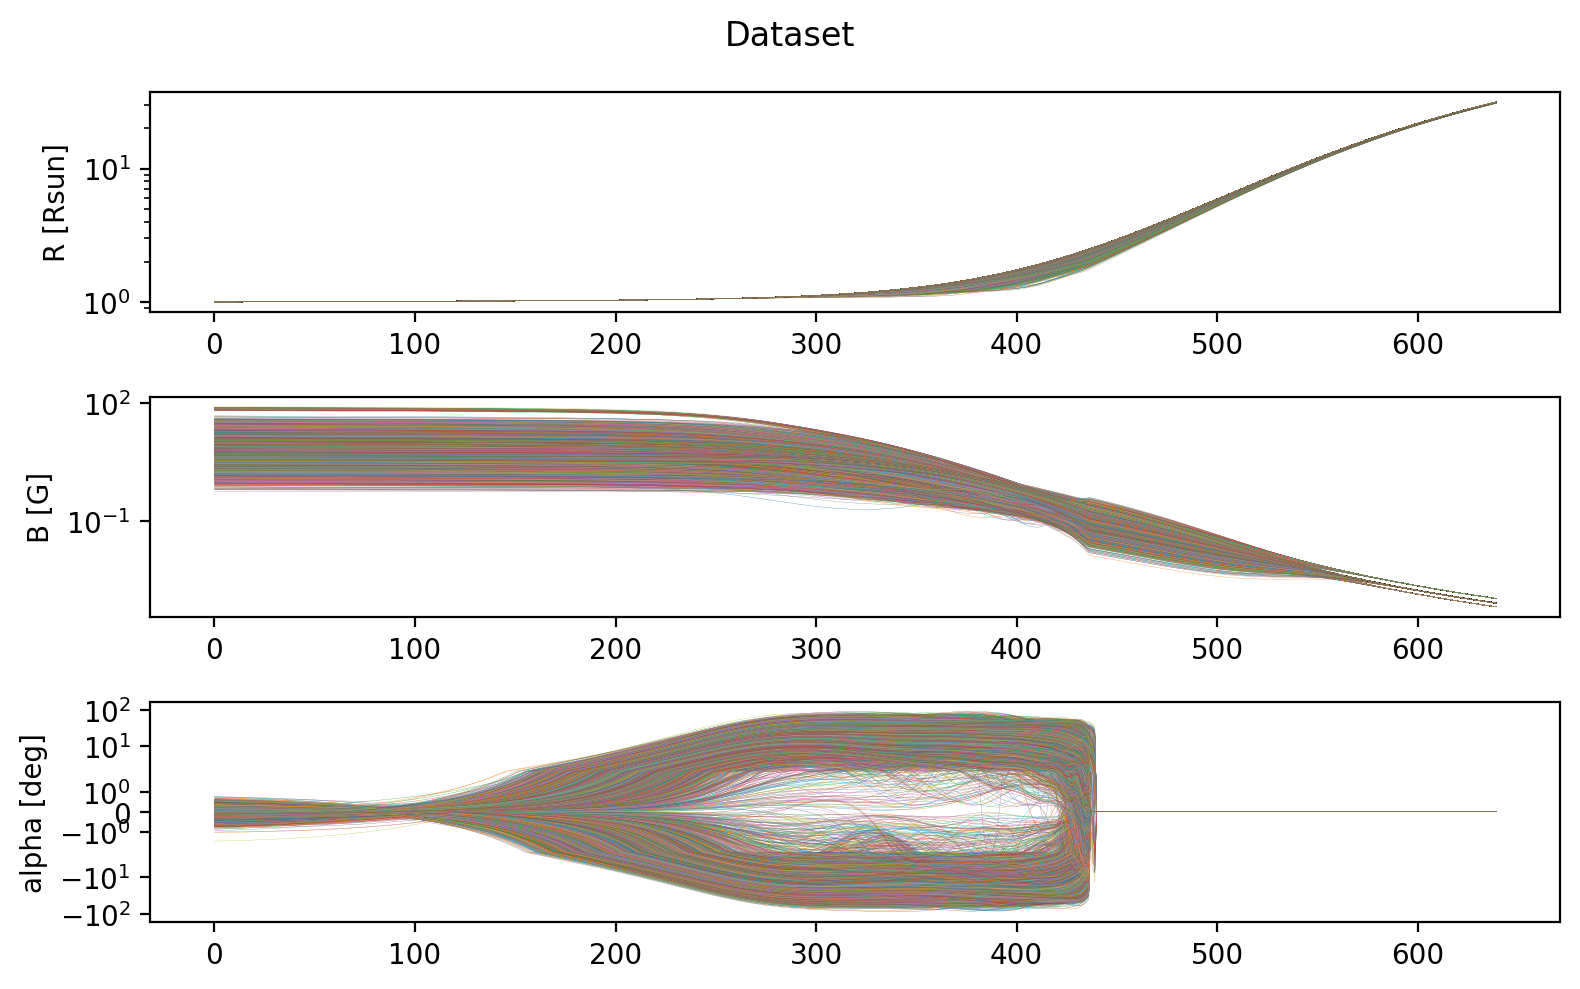

In [67]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/reconstr_scores",
                        scale="log", method="Reconstruction", normal_plot=True)

## Reconstruction + Discriminator

In [68]:
scores_discr = []
loss_fn = nn.MSELoss(reduction="none")
criterion = nn.BCELoss()

# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    bsize = x.shape[0]
    real_labels = torch.full((bsize, 1), 1, dtype=torch.float, device=device)
    
    errG = 0.1 * criterion(netD(enc_x), real_labels) + 0.9 * loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().numpy()
    # errG = loss_fn(dec_x, x).mean(-1)
    # errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        # print(sample, filename)
        scores_discr.append((filename, error))

Anomaly Threshold:  0.07540957
Found 1177 anomalies


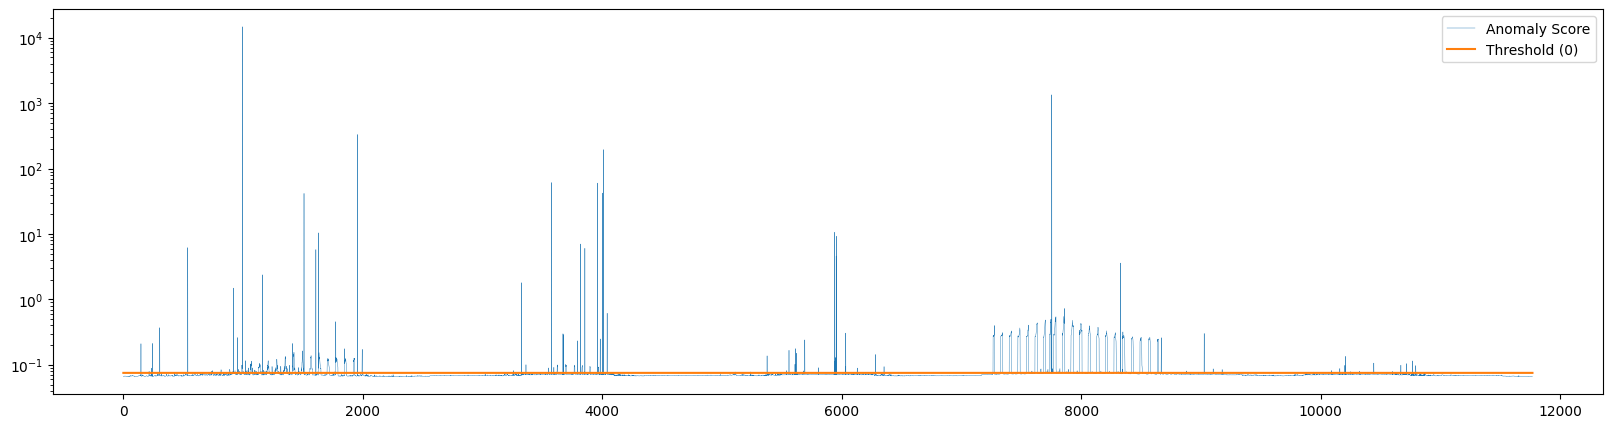

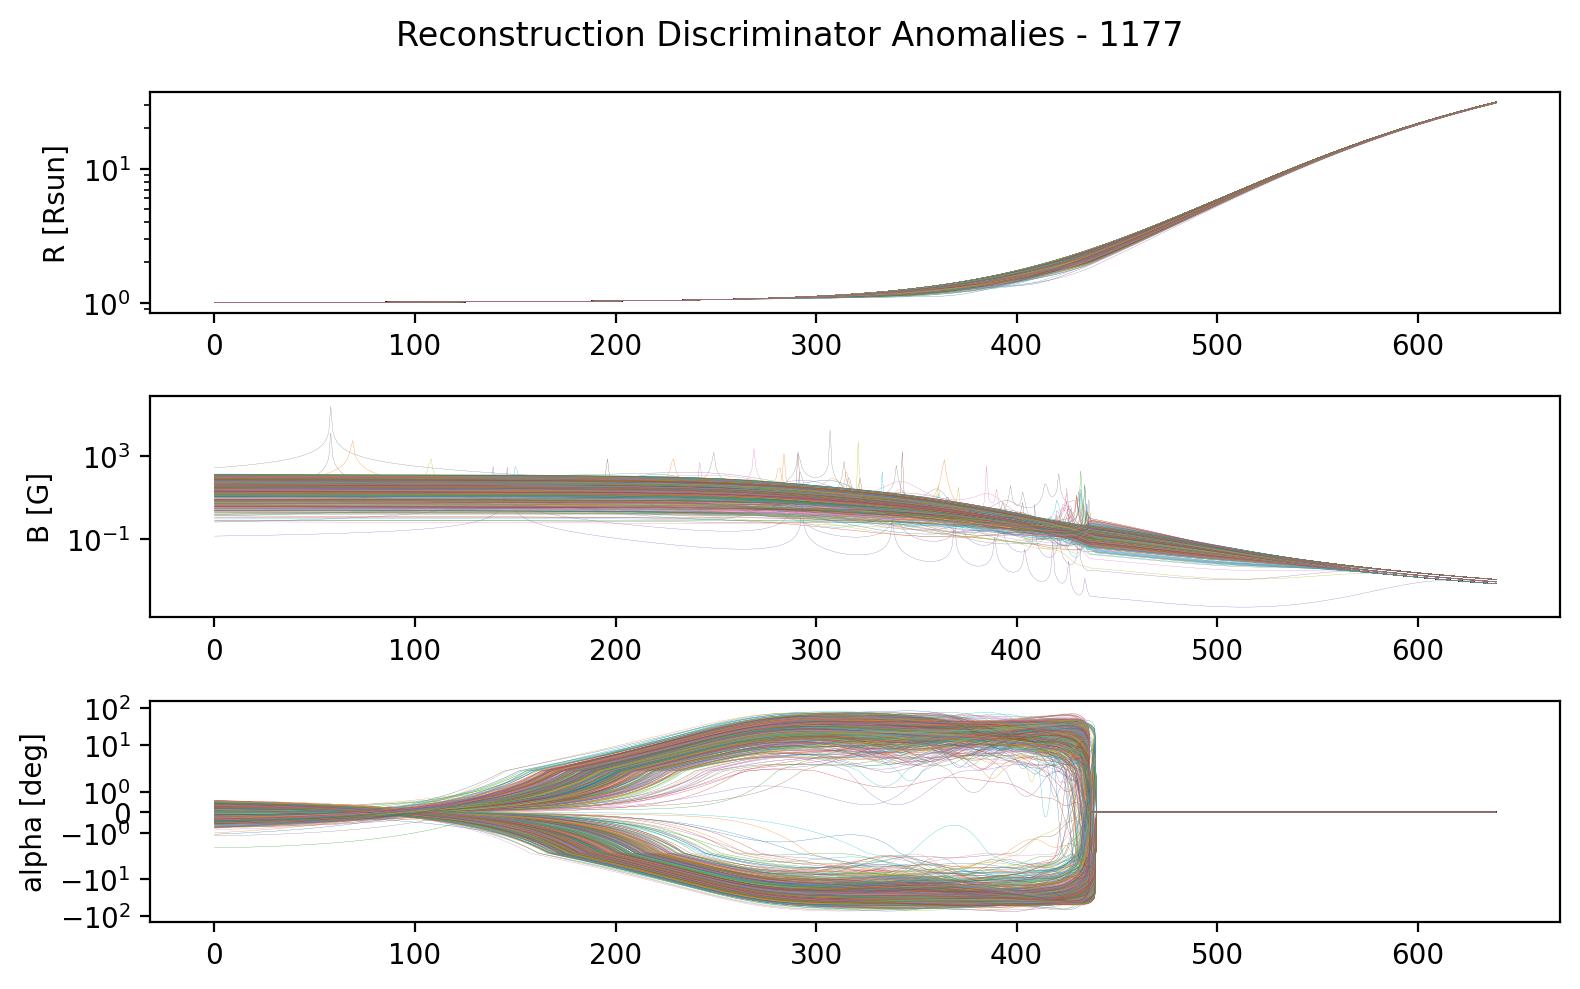

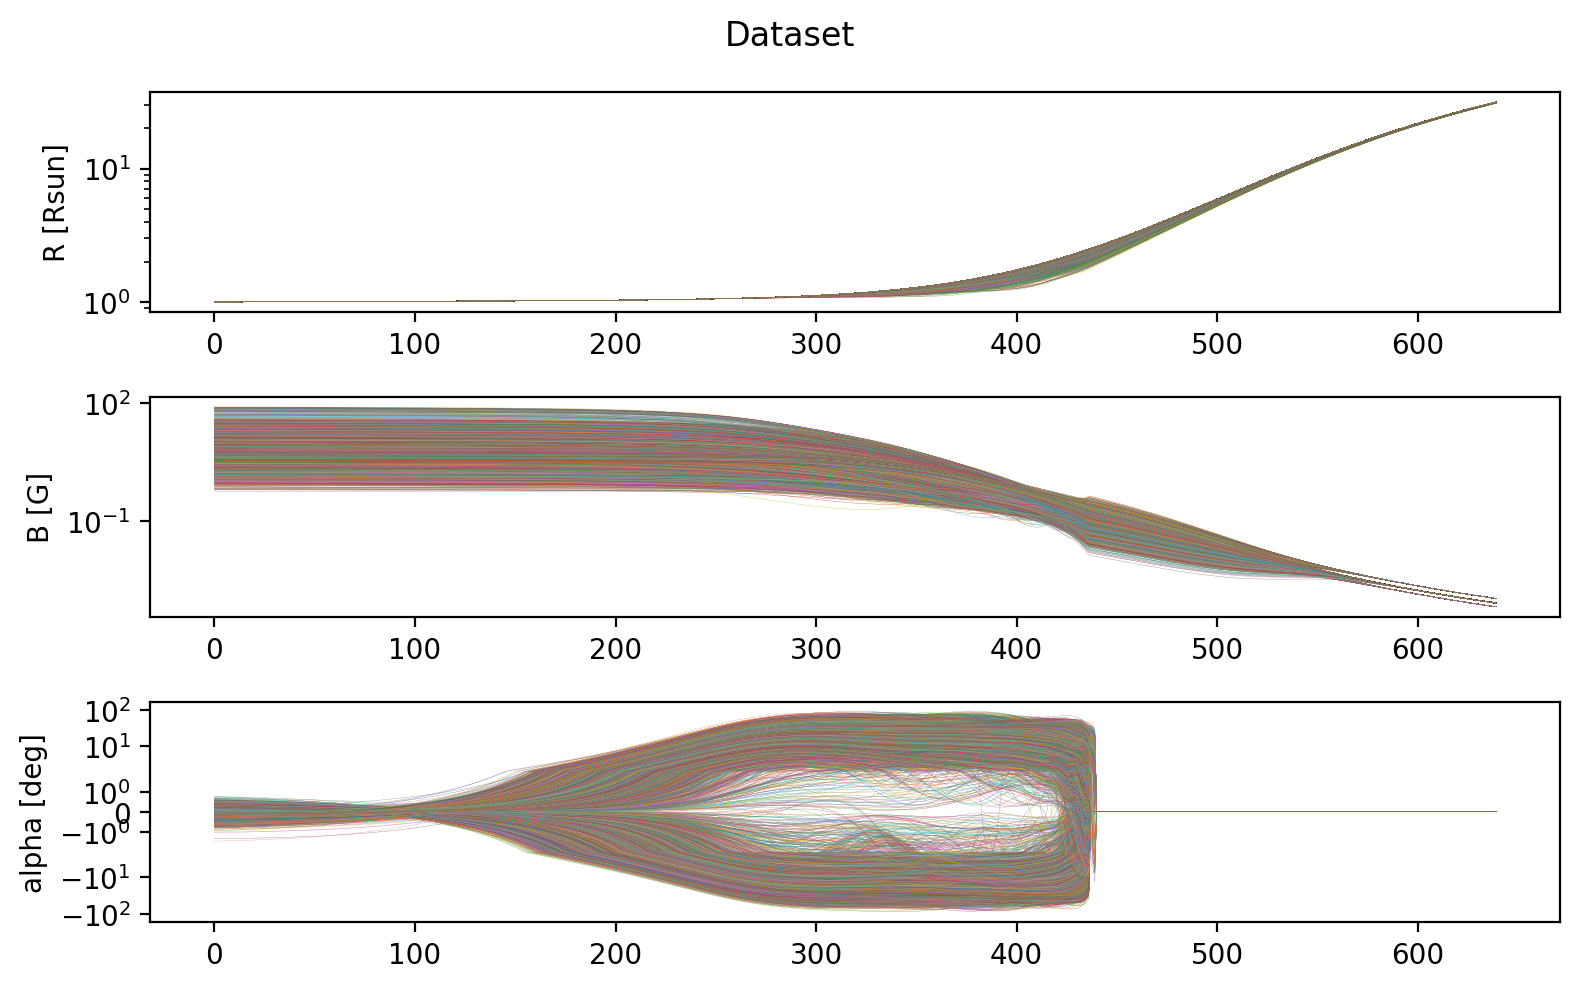

In [69]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/reconstr_discr_scores", 
                        scale="log", method="Reconstruction Discriminator", normal_plot=True)